In [1]:
from OptionPricing import *
from AnalyticFormulas import *
from mpl_toolkits.mplot3d import Axes3D

data_path = 'C:\\Users\\oli-w\\OneDrive\\Uni\\Master Thesis\\Neural-Network-Option-Pricing-Master-Thesis\\Code\\OptionData\\'
plot_path = 'C:\\Users\\oli-w\\OneDrive\\Uni\\Master Thesis\\LaTeX Template\\'

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

lwidth = 1
np.random.seed(seed=123)

nSim = int(1e6)

# 1. One-dimensional Models

In [2]:
# Common specs for all models

r = 0.05
s0 = 100
T = [0.3, 1, 3]

strikes = np.linspace(50, 400, 10000)
moneyness = s0 / strikes

In [3]:
def plot_one_dim_prices(asset_vals, prices, model_name, model_name_short):
    fig = plt.figure(figsize=(4, 2.5))
    ax = fig.add_subplot()
    fig.tight_layout()
    ax.margins(x=0)
    for t in T:
        ax.plot(asset_vals, prices[t], label='$T={}$'.format(t), lw=lwidth)
    ax.set_xlabel('$s_0/K$', fontsize=10)
    ax.set_ylabel('$C(T,K)/K$', fontsize=10)
    ax.set_title('Normalized Call Prices in {} Model'.format(model_name), fontsize=10)
    plt.legend(fontsize=10)
    plt.savefig(plot_path + model_name_short + 'Prices.pdf')

## 1.1 Merton Jump Diffusion Model

In [4]:
# Model specs

lam = 4
mu_Y = -0.1
sig_Y = 0.2
sigma = 0.25

In [5]:
# Option prices (normalized)

prices = {}
for t in T:
    prices[t] = np.array([MertonJumpDiffusionPrice(s, r, sigma, t, 1, mu_Y, sig_Y, lam, nSum=30) for s in moneyness])

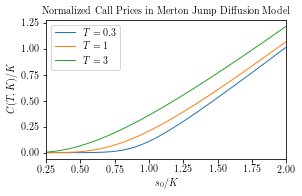

In [6]:
plot_one_dim_prices(moneyness, prices, 'Merton Jump Diffusion', 'Merton')

In [7]:
# Save data

merton_df = pd.DataFrame(prices)
merton_df['s'] = moneyness
merton_df.to_csv(data_path + 'one_dim_merton_prices.csv', index=False)
merton_df.head()

,0.3,1.0,3.0,s
0,1.018033,1.072864,1.220569,2.000000
1,1.016646,1.071520,1.219267,1.998601
2,1.015261,1.070178,1.217967,1.997204
3,1.013878,1.068838,1.216668,1.995808
4,1.012498,1.067500,1.215372,1.994415


## 1.2 NIG Model

In [8]:
# Model specs

theta = 0.1
sigma = 0.4
kappa = 0.2

In [9]:
# Option prices (normalized)

nigModel = NIGModel(theta=theta, sigma=sigma, kappa=kappa, r=r, s0=s0, T=T[-1])
payoff = lambda s: np.maximum(s - 1, 0)

mcPrices = {}
for t in T:
    mcPrices[t] = nigModel.OptionPriceRangeMC(payoffFunc=payoff, assetStartVals=moneyness, expiry=t, nSim=nSim)

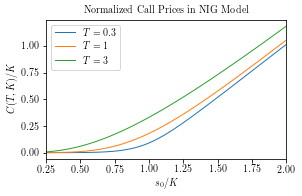

In [10]:
plot_one_dim_prices(moneyness, mcPrices, 'NIG', 'NIG')

In [11]:
# Save data

nig_df = pd.DataFrame(mcPrices)
nig_df['s'] = moneyness
nig_df.to_csv(data_path + 'one_dim_nig_prices.csv', index=False)
nig_df.head()

,0.3,1.0,3.0,s
0,1.015326,1.055810,1.187022,2.000000
1,1.013929,1.054437,1.185707,1.998601
2,1.012534,1.053065,1.184393,1.997204
3,1.011141,1.051696,1.183081,1.995808
4,1.009750,1.050328,1.181772,1.994415


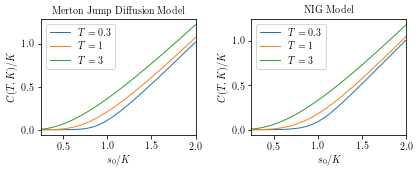

In [12]:
# plot Merton and NIG prices together

fig, ax = plt.subplots(1, 2, figsize=(6,2.5))
fig.tight_layout()
ax[0].margins(x=0)
ax[1].margins(x=0)
for t in T:
    ax[0].plot(moneyness, prices[t], label='$T={}$'.format(t), lw=lwidth)
    ax[1].plot(moneyness, mcPrices[t], label='$T={}$'.format(t), lw=lwidth)
ax[0].set_title('Merton Jump Diffusion Model', fontsize=10)
ax[1].set_title('NIG Model', fontsize=10)
for a in ax:
    a.set_xlabel('$s_0/K$', fontsize=10)
    a.set_ylabel('$C(T,K)/K$', fontsize=10)
    a.legend(fontsize=10)
plt.tight_layout()
plt.savefig(plot_path + 'nig_mertonPrices.pdf')

# 2. Multi-dimensional Models

In [13]:
# Common specs for all models

r = 0.05
T = [0.3, 1, 3]

payoff = lambda s: np.maximum(s.sum(axis=1) - 1, 0)

In [14]:
def save_data(asset_vals, prices, model_name, d):
    df = pd.DataFrame(prices)
    for i in range(1, d+1):
        df['s{}'.format(i)] = asset_vals.T[i-1]
    df.to_csv(data_path + '{}_dim_{}_prices.csv'.format(d, model_name), index=False)
    return df

def generate_correlation(d):
    eigen = np.random.rand(d)
    eigen *= d / eigen.sum()
    return sp.random_correlation.rvs(eigen)

## 2.1 Two-dimensional Models

In [15]:
d = 2
s0 = np.repeat(100, d)
#weights = np.repeat(1 / d, d)
weights = np.array([0.7,0.3])

strikes = np.linspace(50, 400, 5000)
moneyness = ((s0 * weights).reshape((d,1)) / strikes).T

In [16]:
# Plot helper functions

def plot_two_dim_prices(asset_vals, prices, model_name, model_name_short):
    fig = plt.figure(figsize=(4, 2.5))
    ax = fig.add_subplot()
    fig.tight_layout()
    ax.margins(x=0)
    for t in T:
        ax.plot(asset_vals.sum(axis=1), prices[t], label='$T={}$'.format(t), lw=lwidth)
    ax.set_xlabel('$w_1s_{0,1}/K + w_2s_{0,2}/K$', fontsize=10)
    ax.set_ylabel('$C(T,K)/K$', fontsize=10)
    ax.set_title('Normalized Call Prices in {} Model'.format(model_name), fontsize=10)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(plot_path + '2d' + model_name_short + 'Prices.pdf')
    
def plot_two_dim_prices3d(asset_vals, prices, model_name):
    plt.rcParams['grid.linewidth'] = 0.1
    plt.rcParams['grid.color'] = "lightgray"
    fig = plt.figure(figsize=(5,3))
    ax = fig.gca(projection='3d')
    fig.tight_layout()
    x = asset_vals.T[0]
    y = asset_vals.T[1]
    for t in T:
        ax.plot(x, y, prices[t], label='$T={}$'.format(t), lw=lwidth)
    plt.legend(fontsize=10, loc='upper left')
    ax.set_xlabel('$w_1s_{0,1}/K$', fontsize=10)
    ax.set_ylabel('$w_2s_{0,2}/K$', fontsize=10)
    ax.set_zlabel('$C(T,K)/K$', fontsize=10)
    ax.w_xaxis.line.set_color("white")
    ax.w_yaxis.line.set_color("white")
    ax.w_zaxis.line.set_color("white")
    ax.view_init(10, -45)
    ax.set_title('$2$-dimensional {} Model'.format(model_name))
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.tick_params(axis='both', which='minor', labelsize=7)
    plt.tight_layout()
    plt.savefig(plot_path + '2d' + model_name + 'Prices3d.pdf')

## 2.1.1. Two-dim Merton Model

In [17]:
# Model specs

lam = 3
mu_j = np.repeat(-0.1, d)
sig_j = np.repeat(0.2, d)
sig_bm = np.repeat(0.25, d)
Corr_j = generate_correlation(d)
Corr_bm = generate_correlation(d)

print('Jump Correlation')
print(Corr_j)
cov_j = np.diag(sig_j) @ Corr_j @ np.diag(sig_j)
print('Jump Covariance')
print(cov_j)
print('\n')
print('Brownian Motion Correlation')
print(Corr_bm)
cov_bm = np.diag(sig_bm) @ Corr_bm @ np.diag(sig_bm)
print('Brownian Motion Covariance')
print(cov_bm)

Jump Correlation
[[1.         0.04025517]
 [0.04025517 1.        ]]
Jump Covariance
[[0.04       0.00161021]
 [0.00161021 0.04      ]]


Brownian Motion Correlation
[[1.         0.60836758]
 [0.60836758 1.        ]]
Brownian Motion Covariance
[[0.0625     0.03802297]
 [0.03802297 0.0625    ]]


In [18]:
# Option prices (normalized)

multiMertonModel = MultiAssetMertonModel(d=d, lam=lam, mu_j=mu_j, sig_j=sig_j, sig_bm=sig_bm, 
                                         Corr_j=Corr_j, Corr_bm=Corr_bm, r=r, s0=s0, T=T[-1])

mcPrices = {}
for t in T:
    mcPrices[t] = multiMertonModel.OptionPriceRangeMC(payoffFunc=payoff, assetStartVals=moneyness, expiry=t, nSim=nSim)

100%|██████████| 100/100 [14:07<00:00,  8.47s/it]


In [19]:
save_data(moneyness, mcPrices, 'merton', d).head()

,0.3,1.0,3.0,s1,s2
0,1.026305,1.081365,1.210233,1.400000,0.600000
1,1.023611,1.078734,1.207628,1.398042,0.599161
2,1.020925,1.076110,1.205031,1.396090,0.598324
3,1.018249,1.073495,1.202441,1.394143,0.597490
4,1.015580,1.070888,1.199860,1.392202,0.596658


In [20]:
# Save data

save_data(moneyness, mcPrices, 'merton', d).head()

,0.3,1.0,3.0,s1,s2
0,1.026305,1.081365,1.210233,1.400000,0.600000
1,1.023611,1.078734,1.207628,1.398042,0.599161
2,1.020925,1.076110,1.205031,1.396090,0.598324
3,1.018249,1.073495,1.202441,1.394143,0.597490
4,1.015580,1.070888,1.199860,1.392202,0.596658


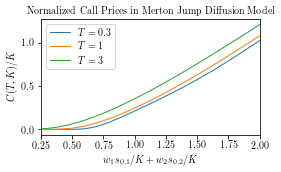

In [21]:
plot_two_dim_prices(moneyness, mcPrices, 'Merton Jump Diffusion', 'Merton')

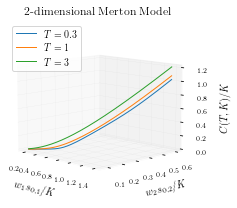

In [22]:
plot_two_dim_prices3d(moneyness, mcPrices, 'Merton')

## 2.1.2 Two-dim NIG Model

In [23]:
# Model specs

theta = np.repeat(0.1, d)
sigma = np.repeat(0.25, d)
kappa = 0.2

Corr_bm = generate_correlation(d)

print('Brownian Motion Correlation')
print(Corr_bm)
cov_bm = np.diag(sig_bm) @ Corr_bm @ np.diag(sig_bm)
print('Brownian Motion Covariance')
print(cov_bm)

Brownian Motion Correlation
[[1.         0.05150938]
 [0.05150938 1.        ]]
Brownian Motion Covariance
[[0.0625     0.00321934]
 [0.00321934 0.0625    ]]


In [24]:
# Option prices (normalized)

multiNigModel = MultiAssetNIGModel(d=d, theta=theta, sigma=sigma, kappa=kappa, Corr=Corr_bm, r=r, s0=s0, T=T[-1])

mcPricesNig = {}
for t in T:
    mcPricesNig[t] = multiNigModel.OptionPriceRangeMC(payoffFunc=payoff, assetStartVals=moneyness, expiry=t, nSim=nSim)

100%|██████████| 100/100 [13:59<00:00,  8.39s/it]


In [25]:
# Save data

save_data(moneyness, mcPricesNig, 'nig', d).head()

,0.3,1.0,3.0,s1,s2
0,1.015166,1.053265,1.152646,1.400000,0.600000
1,1.012385,1.050540,1.149951,1.398042,0.599161
2,1.009612,1.047823,1.147265,1.396090,0.598324
3,1.006848,1.045115,1.144588,1.394143,0.597490
4,1.004091,1.042415,1.141918,1.392202,0.596658


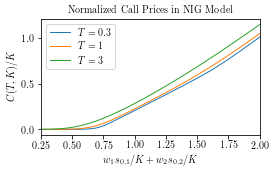

In [26]:
plot_two_dim_prices(moneyness, mcPricesNig, 'NIG', 'NIG')

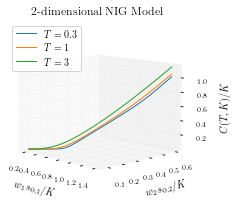

In [27]:
plot_two_dim_prices3d(moneyness, mcPricesNig, 'NIG')

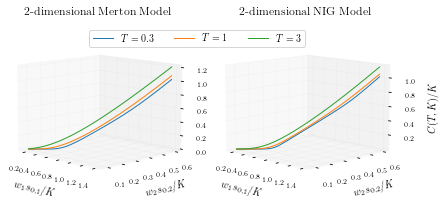

In [28]:
# plot Merton and NIG together

fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
fig.tight_layout()
x = moneyness.T[0]
y = moneyness.T[1]
for t in T:
    ax1.plot(x, y, mcPrices[t], label='$T={}$'.format(t), lw=lwidth)
    ax2.plot(x, y, mcPricesNig[t], label='$T={}$'.format(t), lw=lwidth)
for ax, name in zip([ax1, ax2], ['Merton', 'NIG']):
    ax.set_xlabel('$w_1s_{0,1}/K$', fontsize=10)
    ax.set_ylabel('$w_2s_{0,2}/K$', fontsize=10)
    ax.set_zlabel('$C(T,K)/K$', fontsize=10)
    ax.w_xaxis.line.set_color("white")
    ax.w_yaxis.line.set_color("white")
    ax.w_zaxis.line.set_color("white")
    ax.view_init(10, -45)
    ax.set_title('$2$-dimensional {} Model'.format(name))
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.tick_params(axis='both', which='minor', labelsize=7)
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc=[0.2,0.77], ncol=3)
plt.tight_layout()
plt.savefig(plot_path + '2dNIGMertonPrices3d.pdf')
plt.show()

## 2.2 Thirty-dimensional Models

In [29]:
d = 30
nSim = int(2e5)
s0 = np.repeat(100, d)
weights = np.random.rand(d)
weights /= weights.sum()

strikes = np.linspace(50, 400, 3000)
moneyness = ((s0 * weights).reshape((d,1)) / strikes).T

## 2.2.1 30-dim Merton Model

In [30]:
# Model specs

lam = 3
mu_j = np.repeat(-0.1, d)
sig_j = np.repeat(0.2, d)
sig_bm = np.repeat(0.25, d)

Corr_j = generate_correlation(d)
Corr_bm = generate_correlation(d)

In [31]:
# Option prices (normalized)

multiMertonModel = MultiAssetMertonModel(d=d, lam=lam, mu_j=mu_j, sig_j=sig_j, sig_bm=sig_bm, 
                                         Corr_j=Corr_j, Corr_bm=Corr_bm, r=r, s0=s0, T=T[-1])

mcPrices = {}
for t in T:
    mcPrices[t] = multiMertonModel.OptionPriceRangeMC(payoffFunc=payoff, assetStartVals=moneyness, expiry=t, nSim=nSim)
    save_data(moneyness, mcPrices, 'merton', d) # save after every iteration due to long runtime

100%|██████████| 20/20 [49:43<00:00, 149.19s/it]


In [32]:
# Save data

save_data(moneyness, mcPrices, 'merton', d)

,0.3,1.0,3.0,s1,s2,s3,s4,s5,s6,s7,...,s21,s22,s23,s24,s25,s26,s27,s28,s29,s30
0,1.133111,1.161057,1.237567,0.072780,0.020513,0.036259,0.068556,0.123759,0.117238,0.075426,...,0.032225,0.007164,0.084749,0.107776,0.101561,0.051602,0.007236,0.067835,0.074119,0.005827
1,1.128767,1.156683,1.233149,0.072611,0.020465,0.036175,0.068396,0.123471,0.116965,0.075250,...,0.032150,0.007147,0.084552,0.107525,0.101325,0.051482,0.007219,0.067677,0.073946,0.005813
2,1.124445,1.152332,1.228752,0.072442,0.020418,0.036091,0.068237,0.123184,0.116693,0.075075,...,0.032076,0.007130,0.084355,0.107275,0.101089,0.051362,0.007202,0.067519,0.073774,0.005800
3,1.120144,1.148002,1.224377,0.072274,0.020370,0.036007,0.068079,0.122899,0.116423,0.074901,...,0.032001,0.007114,0.084160,0.107027,0.100855,0.051243,0.007186,0.067363,0.073603,0.005786
4,1.115864,1.143694,1.220024,0.072107,0.020323,0.035924,0.067922,0.122614,0.116153,0.074728,...,0.031927,0.007097,0.083965,0.106779,0.100622,0.051124,0.007169,0.067207,0.073433,0.005773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.000000,0.000000,0.000021,0.009108,0.002567,0.004538,0.008579,0.015488,0.014672,0.009439,...,0.004033,0.000896,0.010606,0.013488,0.012710,0.006458,0.000906,0.008489,0.009276,0.000729
2996,0.000000,0.000000,0.000021,0.009106,0.002566,0.004536,0.008577,0.015483,0.014668,0.009436,...,0.004032,0.000896,0.010603,0.013484,0.012706,0.006456,0.000905,0.008487,0.009273,0.000729
2997,0.000000,0.000000,0.000021,0.009103,0.002566,0.004535,0.008574,0.015479,0.014663,0.009434,...,0.004031,0.000896,0.010600,0.013480,0.012703,0.006454,0.000905,0.008484,0.009270,0.000729
2998,0.000000,0.000000,0.000021,0.009100,0.002565,0.004534,0.008572,0.015474,0.014659,0.009431,...,0.004029,0.000896,0.010597,0.013476,0.012699,0.006452,0.000905,0.008482,0.009268,0.000729


## 2.2.2 30-dim NIG Model

In [33]:
# Model specs

theta = np.repeat(0.1, d)
sigma = np.repeat(0.25, d)
kappa = 0.2
Corr_bm = generate_correlation(d)

In [34]:
# Option prices (normalized)

multiNigModel = MultiAssetNIGModel(d=d, theta=theta, sigma=sigma, kappa=kappa, Corr=Corr_bm, r=r, s0=s0, T=T[-1])

mcPricesNig = {}
for t in T:
    mcPricesNig[t] = multiNigModel.OptionPriceRangeMC(payoffFunc=payoff, assetStartVals=moneyness, expiry=t, nSim=nSim)
    save_data(moneyness, mcPricesNig, 'nig', d) # save after every iteration due to long runtime

100%|██████████| 20/20 [49:45<00:00, 149.26s/it]


In [35]:
# Save data

save_data(moneyness, mcPricesNig, 'nig', d)

,0.3,1.0,3.0,s1,s2,s3,s4,s5,s6,s7,...,s21,s22,s23,s24,s25,s26,s27,s28,s29,s30
0,1.131709,1.157886,1.229292,0.072780,0.020513,0.036259,0.068556,0.123759,0.117238,0.075426,...,0.032225,0.007164,0.084749,0.107776,0.101561,0.051602,0.007236,0.067835,0.074119,0.005827
1,1.127373,1.153516,1.224856,0.072611,0.020465,0.036175,0.068396,0.123471,0.116965,0.075250,...,0.032150,0.007147,0.084552,0.107525,0.101325,0.051482,0.007219,0.067677,0.073946,0.005813
2,1.123057,1.149167,1.220442,0.072442,0.020418,0.036091,0.068237,0.123184,0.116693,0.075075,...,0.032076,0.007130,0.084355,0.107275,0.101089,0.051362,0.007202,0.067519,0.073774,0.005800
3,1.118763,1.144840,1.216050,0.072274,0.020370,0.036007,0.068079,0.122899,0.116423,0.074901,...,0.032001,0.007114,0.084160,0.107027,0.100855,0.051243,0.007186,0.067363,0.073603,0.005786
4,1.114489,1.140534,1.211680,0.072107,0.020323,0.035924,0.067922,0.122614,0.116153,0.074728,...,0.031927,0.007097,0.083965,0.106779,0.100622,0.051124,0.007169,0.067207,0.073433,0.005773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.000000,0.000000,0.000003,0.009108,0.002567,0.004538,0.008579,0.015488,0.014672,0.009439,...,0.004033,0.000896,0.010606,0.013488,0.012710,0.006458,0.000906,0.008489,0.009276,0.000729
2996,0.000000,0.000000,0.000003,0.009106,0.002566,0.004536,0.008577,0.015483,0.014668,0.009436,...,0.004032,0.000896,0.010603,0.013484,0.012706,0.006456,0.000905,0.008487,0.009273,0.000729
2997,0.000000,0.000000,0.000003,0.009103,0.002566,0.004535,0.008574,0.015479,0.014663,0.009434,...,0.004031,0.000896,0.010600,0.013480,0.012703,0.006454,0.000905,0.008484,0.009270,0.000729
2998,0.000000,0.000000,0.000003,0.009100,0.002565,0.004534,0.008572,0.015474,0.014659,0.009431,...,0.004029,0.000896,0.010597,0.013476,0.012699,0.006452,0.000905,0.008482,0.009268,0.000729
